In [62]:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#1introduction
# TO USE:
# Uncomment three !pip install lines
# Run this cell ONLY
# Runtime -> Restart session
# Comment three !pip install lines
# Run all

# Andy can push

# Pandas 1.5.3
# Numpy 1.26.3
# Json 2.0.9
# NLTK (Natural Language Toolkit) 3.8.1
# Gensim 4.3.2
# Spacy 3.6.1
# PyLDAvis 3.4.0
# re (removing characters) 2.2.1
# clean from cleantext
# from prompt_toolkit.completion import word_completer
# from pprint import pprint
# import matplotlib.pyplot as plt


%pip install pyLDAvis
%pip install --user -U nltk
%pip install -U spacy
%pip install "pandas==1.5.3"

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.2.1-cp39-cp39-macosx_11_0_arm64.whl (11.3 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
N

In [63]:
#

import numpy as np
import json
import glob
import nltk
import pandas as pd #to work with csv files

# pd.__version__ = 2.0.0
print(pd.__version__)

#Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#spacy
import spacy
from nltk.corpus import stopwords

#vis
import pyLDAvis
import pyLDAvis.gensim

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

1.5.3


In [64]:
import os
#The function that loops through the data to check for optimal parameters to input into the LDA model would take over 16 hours to run,
#after a while the runtime disconnects, which makes the progress start from 0.
#so the purpose of this function is to make sure the runtime doesnt disconnect, while training for optimal params to input to lda model.

#def check_and_reconnect_drive():
    #try:
        # Check if Google Drive is still connected
     #   os.listdir('/content/drive')
  #  except:
        # If not, reconnect it
  #      from google.colab import drive
  #      drive.mount('/content/drive', force_remount=True)

# Then call this function every so often in your main script
#check_and_reconnect_drive()

In [65]:
nltk.download('stopwords')

stopwords = stopwords.words("english") #get stopwords from nltk

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chuongnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [66]:
#stopwords.extend(['hi', 'anymore', 'years', 'ago', 'almost', 'somehow', 'remember', 'wants', 'either', 'enough', 'much', 'making', 'simple', 'things', 'add', 'actual', 'say', 'etc', 'anything', 'days', 'long', 'another', 'ever', 'yes', 'th', 'ice', 'mightymouse', 'should', 'obviously', 'even', 'lol', 'stuff', 'never', 'old', 'yr', 'bit', 'like', 'aka', 'nonsense', 'ok', 'absolutely', 'op', 'weird', 'ass', 'fully', 'get', 'would', 'definitely', 'especially', 'still', 'else', 'something', 'often', 'kind', 'let', 'lot', 'able', 'non', 'pg', 'nice', 'trad', 'keep', 'massive', 'quickly', 'be', 'common', 'tv', 'fuckin', 'im', 'could', 'also', 'silly', 'ie', 'seem', 'seems', 'fucked'])#Add custom stop words
stopwords.extend(['r/parenting', 'r/roblox', 'get'])#Add reddit paths

In [67]:
def wordcounts(text1):
  fdist1 = FreqDist(text1)
  print(fdist1)
  fdist1.most_common(50)

In [68]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

In [69]:
def load_data(file):
  data = pd.read_csv(file)
  return data

In [70]:
data = load_data('../Used_Dataset/finalCumulative.csv')
filtered_data = data.drop(columns=['subreddit','date','timestamp'], axis=1)
data = filtered_data.replace('\n', ' ', regex=True)
# data.head(5)

In [71]:
# data[data.text.str.contains('I am a bot')]

In [72]:
import re

data = data.loc[data.text.str.contains('I am a bot') == False, :]

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
data['text'] = data['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

data['text'] = data['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\(', ' ', x))
data['text'] = data['text'].map(lambda x: re.sub('\)', ' ', x))
data['text'] = data['text'].replace(r'&\S+', '', regex=True)
data['text'] = data['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
data['text'] = data['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
data['text'] = data['text'].map(lambda x: re.sub(pattern, ' ', x))
data['text'] = data['text'].map(lambda x: re.sub(' +', ' ', x))

data.shape

(22911, 2)

In [73]:
data.columns

Index(['Unnamed: 0', 'text'], dtype='object')

In [74]:
data.head(5)

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [75]:
data[data.text.str.contains('I am a bot')]

,Unnamed: 0,text


In [76]:
data['text'][51]

"hey i'm not a parent but i have a little brother and i'm consered for him because in most games he plays there's the blox ____ scams i won't actually say the links because people could accidentally click it but i have to remind him every time he plays mom won't let him spend money on there cuz he's too young so he's trying to get free robux "

In [77]:
!pip install clean-text
from cleantext import clean

  Using cached clean_text-0.6.0-py3-none-any.whl (11 kB)
  Using cached emoji-1.7.0.tar.gz (175 kB)
  Preparing metadata (setup.py) ... done
  Using cached ftfy-6.1.3-py3-none-any.whl (53 kB)
  Using cached wcwidth-0.2.13-py2.py3-none-any.whl (34 kB)
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171032 sha256=ee9f39a7fd34013688427ce2f7b6ebc187b353f8bf785067ed9883d08f57f06b
  Stored in directory: /Users/chuongnguyen/Library/Caches/pip/wheels/fa/7a/e9/22dd0515e1bad255e51663ee513a2fa839c95934c5fc301090
Successfully built emoji
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth-0.2.5


In [78]:
data = [clean(d, no_emoji=True) for d in data['text']]

In [79]:
data = remove_stopwords(data)

In [80]:
resultx = []
for d in data:
  resultx.append(' '.join(d))

#resultxtokens = resultx.split()


In [81]:
resultx[:5]

['concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss amon

In [82]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
words = [word_tokenize(i) for i in resultx]
words2= [num for elem in words for num in elem]
#words = nltk.tokenize.word_tokenize(resultx)

#wordcounts(words2)
fdist1 = FreqDist(words2)
#print(fdist1)
fdist1.most_common(50)


#>>> # flatten a list using a listcomp with two 'for'
#>>> vec = [[1,2,3], [4,5,6], [7,8,9]]
#>>> [num for elem in vec for num in elem]
#[1, 2, 3, 4, 5, 6, 7, 8, 9]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/chuongnguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('game', 6524),
 ('like', 5984),
 ('games', 5246),
 ('kids', 4437),
 ('roblox', 4332),
 ('play', 3403),
 ('time', 3397),
 ('would', 2991),
 ('people', 2948),
 ('one', 2532),
 ('think', 2462),
 ('also', 2443),
 ('money', 2409),
 ('make', 2397),
 ('know', 2375),
 ('good', 2314),
 ('kid', 2313),
 ('even', 2248),
 ('old', 2155),
 ('year', 2033),
 ('really', 2012),
 ('pokemon', 1922),
 ('want', 1867),
 ('much', 1857),
 ('things', 1834),
 ('still', 1804),
 ('something', 1746),
 ('way', 1703),
 ('playing', 1580),
 ('better', 1486),
 ('could', 1458),
 ('let', 1449),
 ('child', 1422),
 ('buy', 1403),
 ('phone', 1401),
 ('see', 1379),
 ('need', 1359),
 ('got', 1343),
 ('go', 1313),
 ('never', 1286),
 ('lot', 1277),
 ('say', 1275),
 ('friends', 1266),
 ('back', 1264),
 ('going', 1260),
 ('thing', 1247),
 ('son', 1240),
 ('well', 1227),
 ('daughter', 1215),
 ('bad', 1210)]

In [83]:
result = []
for d in data:
  result.append(' '.join(d))
# result

In [84]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# data = filtered_data.review_text_processed.values.tolist()
data_words = list(sent_to_words(result))

# prints the first 30 words of the first tokenized review from the data_words list.
# print(data_words[:1][0][:30])

In [85]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [86]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [87]:
# # NO BIGRAMS
# !python -m spacy download en_core_web_sm
# import spacy

# # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# # Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [88]:
# BIGRAMS DATA
!python -m spacy download en_core_web_sm
import spacy

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for unigram
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram
# data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']) # for bigram


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 13.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [89]:
print(type(data_lemmatized))

<class 'list'>


Remove Duplicate Words (TO REMOVE)

In [90]:
# from collections import Counter
# def unique(d):
#   UniqW = Counter(d)
#   result = [*UniqW]
#   # corpus = ' '.join(UniqW.keys())
#   return result

In [91]:
# single_data = []
# for d in data_lemmatized:
#   for word in d:
#     single_data.append(word)

In [92]:
# unique_data = [unique(d) for d in data_lemmatized]
# # unique_data = unique(single_data)

In [93]:
# print(type(unique_data))

In [94]:
# unique_data

In [95]:
from prompt_toolkit.completion import word_completer
id2word = corpora.Dictionary(data_lemmatized)
# id2word = corpora.Dictionary(bag_of_words)

corpus = []
for text in data_lemmatized:
  new = id2word.doc2bow(text)
  corpus.append(new)

print(corpus[0])

print(data_words[:1][0][:30])
# print(word_completer)

[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 2), (12, 7), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 1), (30, 2), (31, 1), (32, 10), (33, 4), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 4), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 3), (48, 1), (49, 1), (50, 4), (51, 2), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 2), (58, 4), (59, 1), (60, 1), (61, 5), (62, 3), (63, 1), (64, 1), (65, 2), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 5), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 3), (92, 2), (93, 1), (94, 1), (95, 3), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 2), (102, 1), (103, 1), (104, 2), (105, 3), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [96]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=5,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.01,
                                       eta=0.61)

In [97]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

/Users/chuongnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.069304 -0.149533       1        1  39.651855
1      0.147010 -0.060337       2        1  28.669230
3     -0.101183 -0.080281       3        1  24.620281
4     -0.129241  0.121268       4        1   4.037093
0      0.014109  0.168883       5        1   3.021541, topic_info=        Term          Freq         Total Category  logprob  loglift
32      game  10160.000000  10160.000000  Default  30.0000  30.0000
74    roblox   2910.000000   2910.000000  Default  29.0000  29.0000
887  pokemon   1710.000000   1710.000000  Default  28.0000  28.0000
326     look   2218.000000   2218.000000  Default  27.0000  27.0000
40       kid   6037.000000   6037.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
41      know     42.419225   2593.600497   Topic5  -5.7223  -0.6138
244     even     39.591802   2066.252110   Topic5  -5.7912  -0.4555
46      make     39.139080   4074.023780   Topic5  -5.8027  -1.1459
101     take     32.820892   1779.479911   Topic5  -5.9788  -0.4936
9        buy     31.230400   2166.705153   Topic5  -6.0285  -0.7402

[389 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
468       3  0.971857      aaa
756       1  0.090056   access
756       2  0.884015   access
756       3  0.025730   access
926       1  0.001385  account
...     ...       ...      ...
350       5  0.000769     year
569       1  0.843089  youtube
569       2  0.146520  youtube
569       3  0.002402  youtube
569       4  0.007206  youtube

[1176 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

In [98]:
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"look" + 0.011*"cod" + 0.010*"lol" + 0.009*"game" + 0.008*"people" + '
  '0.006*"say" + 0.005*"post" + 0.005*"comment" + 0.005*"reddit" + '
  '0.005*"shit"'),
 (1,
  '0.017*"kid" + 0.014*"money" + 0.012*"phone" + 0.011*"make" + 0.010*"use" + '
  '0.010*"child" + 0.009*"roblox" + 0.009*"need" + 0.008*"want" + '
  '0.008*"give"'),
 (2,
  '0.025*"play" + 0.023*"kid" + 0.018*"game" + 0.012*"time" + 0.011*"old" + '
  '0.009*"go" + 0.009*"year" + 0.009*"think" + 0.009*"thing" + 0.009*"want"'),
 (3,
  '0.057*"game" + 0.016*"pokemon" + 0.014*"buy" + 0.014*"look" + 0.013*"make" '
  '+ 0.012*"people" + 0.010*"well" + 0.010*"play" + 0.009*"good" + '
  '0.007*"even"'),
 (4,
  '0.026*"game" + 0.021*"roblox" + 0.006*"play" + 0.006*"minecraft" + '
  '0.005*"shoe" + 0.005*"good" + 0.005*"pet" + 0.005*"player" + 0.004*"adopt" '
  '+ 0.003*"find"')]


In [99]:
from gensim.models import CoherenceModel

# Compute Coherence Score

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
# coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, corpus=corpus, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Coherence Score:  0.5926494659767043


In [100]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
for idx in reviews_in_topic_1:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

concerned parents roblox scams cash grab games pretty much force children rebuy game packs already ok title says sick seeing games clearly cash grab blind recently checking son begging robux take example ninja legends guys put shine original game put number end nothing new second game checked sons tablet people run roblox let stuff fly games like rename original game call new forces children buy packs already sad part many small children fall beg parents buy robux pay something already got highway robbery something needs done soon roblox seems getting worse robux scams need constantly monitor kid falling make sure game creators ripping kids many parents community going start stepping soon try getting news something done soon stuff stop need stop letting people like take advantage children edit forgot add also play games children roblox like bee swarm simulator couple others know seeing scam something fishing going update ok got needed thread still stop reply leave people discuss among 

In [101]:

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaModel(corpus=corpus,
                                       id2word=dictionary,
                                       num_topics=k,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       alpha=a,
                                       eta=b,
                                       per_word_topics=True)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

#data_words

In [102]:
# import numpy as np
# import tqdm
# grid = {}
# grid['Validation_Set'] = {}

#  # Topics range
# min_topics = 2
# max_topics = 11
# step_size = 1
# topics_range = range(min_topics, max_topics, step_size)
# # Alpha parameter
# #A list of alpha values to be tested.
# #It includes a range of values from 0.01 to 1 with a step size of 0.3, as well as two special values: 'symmetric' and 'asymmetric'.
# alpha = list(np.arange(0.01, 1, 0.3))
#  #assumes that all documents are equally likely to be a mixture of topics, resulting in a uniform distribution of topics across documents. So it maps rreviews to each topic evenly
#  #It makes the model assume that every document should have roughly the same proportion of topics.
# # alpha.append('symmetric')
# # #allows for more variability in document-topic proportions.
# # #It doesn't enforce a uniform distribution and allows documents to have varying degrees of focus on different topics.
# alpha.append('asymmetric')

# # # Beta parameter
# # #A list of beta values to be tested. It follows a similar pattern to alpha, including a range and 'symmetric'.
# beta = list(np.arange(0.01, 1, 0.3))
# beta.append('symmetric')

# # # Validation sets:
# # # We have the corpus sets, which contains 2 versions of the corpus, 15% and 20%
# num_of_docs = len(corpus)

# # #A list containing two versions of the 15% corpus, one with 20% of the documents and another with 15% of the documents.
# corpus_sets = [gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.20)),
#                gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.15))]

# corpus_title = ['20% Corpus', '15% Corpus']

# #Stores the results of the LDA model with different hyperparameters.
# model_results = {'Validation_Set': [],
#                   'Topics': [],
#                   'Alpha': [],
#                   'Beta': [],
#                   'Coherence': []
#                  }

#  # Can take a long time to run
# if 1 == 1:
#    #progress bar
#     pbar = tqdm.tqdm(total=(len(beta)*len(alpha)*len(topics_range)*len(corpus_title)))

#      # iterate through validation corpus sets
#     for i in range(len(corpus_sets)):
#          # iterate through number of topics
#         for k in topics_range:
#              # iterate through alpha values
#             for a in alpha:
#                  # iterare through beta values
#                 for b in beta:
#                      #reconnect the runtime
#                    # check_and_reconnect_drive()
#                      # get the coherence score for the given parameters
#                     cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word,
#                                                   k=k, a=a, b=b)

#                      # Save the model results
#                     model_results['Validation_Set'].append(corpus_title[i])
#                     model_results['Topics'].append(k)
#                     model_results['Alpha'].append(a) 
#                     model_results['Beta'].append(b)
#                     model_results['Coherence'].append(cv)
#                     pbar.update(1)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#      # pd.DataFrame(model_results).to_csv('/content/drive/My Drive/Classes/lda_tuning_results.csv', index=False)
#     pbar.close()

In [103]:
import os


print(os.getcwd())

/Users/chuongnguyen/Desktop/2023-2024 School Work/Winter Quarter 2024/ERSP/LDA_Analysis-1/Code


In [104]:
# if 1==1:
# # pd.DataFrame(model_results).to_csv('./results/lda_tuning_results.csv', index=False)
#     pd.DataFrame(model_results).to_csv('../Dataset/lda_tuning_results.csv', index=False)
#     pbar.close()

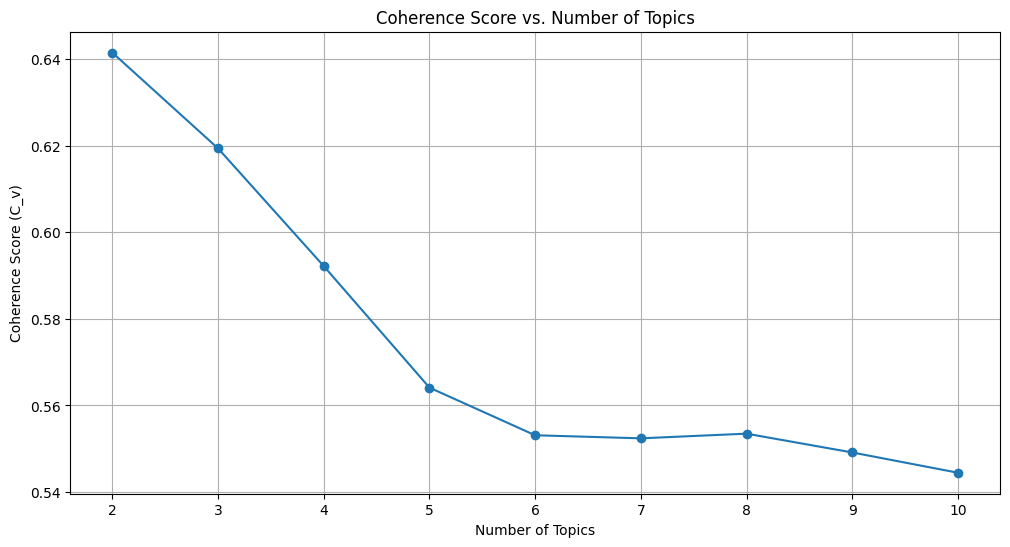

In [105]:
!pip install matplotlib
import matplotlib.pyplot as plt
import pandas as pd

# Load the model results from the CSV file
model_results_df = pd.read_csv('../Dataset/lda_tuning_results.csv')

# Filter the results for the 75% Corpus (you can change this if needed)
# filtered_results = model_results_df[model_results_df['Validation_Set'] == '20% Corpus']

# Group the results by the number of topics (Topics) and calculate the mean coherence score
coherence_by_topics = model_results_df.groupby('Topics')['Coherence'].mean()

# Plot the coherence score against the number of topics
plt.figure(figsize=(12, 6))
plt.plot(coherence_by_topics.index, coherence_by_topics.values, marker='o', linestyle='-')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_v)')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [106]:
data_topic_3 = model_results_df[model_results_df['Topics'] == 2]
max_coherence = np.array(data_topic_3['Coherence'])
print(max(model_results_df['Coherence']))
#print(max_coherence[4])
#print(np.argmax(max_coherence))

0.723257906711438


##Visualizing the Data


In [107]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word, mds='mmds', R=30)
vis

/Users/chuongnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.069304 -0.149533       1        1  39.657118
1      0.147010 -0.060337       2        1  28.670450
3     -0.101183 -0.080281       3        1  24.610020
4     -0.129241  0.121268       4        1   4.037488
0      0.014109  0.168883       5        1   3.024925, topic_info=        Term          Freq         Total Category  logprob  loglift
32      game  10158.000000  10158.000000  Default  30.0000  30.0000
74    roblox   2910.000000   2910.000000  Default  29.0000  29.0000
887  pokemon   1709.000000   1709.000000  Default  28.0000  28.0000
326     look   2218.000000   2218.000000  Default  27.0000  27.0000
40       kid   6038.000000   6038.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
41      know     42.466728   2593.660635   Topic5  -5.7223  -0.6138
244     even     39.636138   2066.107564   Topic5  -5.7912  -0.4554
46      make     39.182909   4073.702709   Topic5  -5.8027  -1.1458
101     take     32.857646   1779.546371   Topic5  -5.9788  -0.4936
9        buy     31.265373   2166.156119   Topic5  -6.0285  -0.7399

[389 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
468       3  0.972245      aaa
756       1  0.090052   access
756       2  0.883979   access
756       3  0.025729   access
926       1  0.001385  account
...     ...       ...      ...
350       5  0.000769     year
569       1  0.842989  youtube
569       2  0.146502  youtube
569       3  0.002402  youtube
569       4  0.007205  youtube

[1177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 5, 1])

In [108]:
lda_model_tuned = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=9,
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True,
                                       alpha=0.9099999999999999,
                                       eta=0.9099999999999999)

In [130]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_tuned, corpus, id2word, mds='mmds', R=30)
pyLDAvis.save_html(vis, "../Output_Plots/output_filename.html")
vis

/Users/chuongnguyen/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.247404 -0.023499       1        1  43.998387
5     -0.007061  0.221620       2        1  17.249190
6     -0.141981  0.098985       3        1  14.700991
0      0.026853 -0.084247       4        1   4.399150
2      0.053805 -0.074171       5        1   4.374775
3      0.057953 -0.012391       6        1   4.130707
4      0.096481 -0.057724       7        1   4.064059
1      0.086366 -0.037970       8        1   3.615086
7      0.074988 -0.030603       9        1   3.467655, topic_info=        Term         Freq        Total Category  logprob  loglift
32      game  9012.000000  9012.000000  Default  30.0000  30.0000
156    money  1830.000000  1830.000000  Default  29.0000  29.0000
40       kid  5283.000000  5283.000000  Default  28.0000  28.0000
887  pokemon  1594.000000  1594.000000  Default  27.0000  27.0000
9        buy  2132.000000  2132.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
34        go    14.180637  2924.697923   Topic9  -6.9557  -1.9674
82       see    13.517388  1713.364889   Topic9  -7.0036  -1.4805
290   really    12.806760  1537.466857   Topic9  -7.0576  -1.4262
41      know    12.796952  2227.133139   Topic9  -7.0584  -1.7976
106     time    12.807869  3008.068070   Topic9  -7.0575  -2.0973

[541 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
468       1  0.014005     aaa
468       2  0.896334     aaa
468       3  0.014005     aaa
468       4  0.014005     aaa
468       5  0.014005     aaa
...     ...       ...     ...
3179      5  0.897060  zombie
3179      6  0.015467  zombie
3179      7  0.015467  zombie
3179      8  0.015467  zombie
3179      9  0.015467  zombie

[3690 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 6, 7, 1, 3, 4, 5, 2, 8])

In [110]:
# Get the topic distribution for each document
document_topics = lda_model.get_document_topics(corpus)
print(document_topics)


In [111]:
# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 1
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')


There are 5088 reviews in topic 1.


In [112]:
#import pandas as pd
#reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

#mixture = [dict(lda_model[x]) for x in corpus]
pd.DataFrame(reviews_in_topic_1).to_csv("topic_mixture.csv")

In [113]:
print(max(document_topics))

[(4, 0.99911183)]


In [114]:
# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 5
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')

There are 0 reviews in topic 5.


In [115]:
 # The code blocks below output the comments into .csv files!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!  

#Preprocessing stuff
datax= load_data('../Used_Dataset/finalCumulative.csv') #Accesses finalCumulative.csv and loads it into the DataFrame called datax
filtered_data = datax.drop(columns=['subreddit','date','timestamp'], axis=1) # Pulls out the 'subreddit', 'date', and 'timestamp' columns from the DataFrame and puts it into filtered_data
datax= filtered_data.replace('\n', ' ', regex=True) # Replaces all newline characters with a space in the 'text' column of the DataFrame
import re

datax= datax.loc[datax.text.str.contains('I am a bot') == False, :] # Removes all rows from the DataFrame that contain the string 'I am a bot' in the 'text' column

# Remove punctuation
# data['text'] = data['text'].map(lambda x: re.sub("[,\.!?/@#$^&*-_=+()%]", "", x))
datax['text'] = datax['text'].replace(r'http\S+', '', regex=True)

#data['text'] = data['text'].replace(r'a'+ u'\u0301'+ 'U+20AC'+ 'U+2122', "'" , regex=True)

datax['text'] = datax['text'].map(lambda x: re.sub('[%$:,\.!?/-]', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\(', ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub('\)', ' ', x))
datax['text'] = datax['text'].replace(r'&\S+', '', regex=True)
datax['text'] = datax['text'].replace('\"', '', regex=True)

# # Convert the titles to lowercase
datax['text'] = datax['text'].map(lambda x: x.lower())

pattern = r'[0-9]'
datax['text'] = datax['text'].map(lambda x: re.sub(pattern, ' ', x))
datax['text'] = datax['text'].map(lambda x: re.sub(' +', ' ', x))

datax.shape

(22911, 2)

In [116]:
datax.head(5) #Displays the first 5 rows of the DataFrame datax

,Unnamed: 0,text
0,0,concerned parents roblox scams and cash grab g...
1,1,roblox the corporation doesn't exactly control...
2,2,this is something i can agree with its serious...
3,3,thats pretty much every simulator in a nutshel...
4,4,basically all these simulator games are mostly...


In [117]:
#This block can be skipped  (but i decided to include it because it defines resultx2, which is used in the future blocks)
datax['text'][3]
type(datax['text'][3])

resultx2 = [] #Creates an empty list called resultx2
for d in datax['text']:
  resultx2.append(d)

#resultx2.head[5]

In [118]:
# Get the comments w/o weird spaces
    
# Get the topic distribution for each document
document_topics = lda_model_tuned.get_document_topics(corpus) #Initially it was lda_model.get_document_topics(corpus), but Natasha changed it to lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1_tuned: #changed this to tuned for the other topics
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Data.csv') #Unsure what this does, Munyaka had this in her code but this seems to produce the same file as topic1


#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)


In [119]:
print(f"reviews_in_topic_1 = {reviews_in_topic_1}")
print(f"reviews_in_topic_1_tuned = {reviews_in_topic_1_tuned}")

reviews_in_topic_1 = [0, 1, 5, 11, 16, 25, 27, 29, 30, 32, 33, 35, 37, 44, 50, 51, 54, 55, 58, 59, 66, 68, 79, 83, 87, 90, 93, 99, 102, 109, 115, 116, 119, 123, 124, 128, 130, 131, 135, 136, 146, 148, 149, 152, 153, 154, 156, 158, 162, 168, 169, 172, 174, 176, 179, 180, 186, 188, 190, 196, 206, 207, 209, 210, 211, 214, 215, 217, 219, 222, 225, 226, 230, 232, 234, 241, 242, 246, 248, 249, 255, 256, 258, 260, 261, 263, 264, 272, 274, 276, 277, 279, 280, 284, 285, 287, 289, 300, 301, 302, 305, 310, 312, 313, 314, 321, 322, 323, 324, 325, 326, 329, 343, 350, 352, 360, 361, 362, 365, 367, 368, 370, 371, 372, 373, 374, 375, 378, 379, 380, 384, 385, 386, 387, 388, 389, 390, 393, 394, 395, 397, 399, 400, 401, 402, 403, 405, 406, 407, 408, 411, 412, 413, 424, 427, 429, 430, 431, 436, 437, 440, 448, 451, 452, 453, 454, 455, 457, 458, 465, 466, 467, 468, 469, 470, 474, 478, 479, 484, 490, 494, 497, 501, 507, 511, 513, 515, 517, 522, 523, 524, 530, 533, 534, 535, 536, 538, 539, 553, 569, 582, 584,

In [120]:
#CAN BE SKIPPED    
# Get the topic distribution for each document
document_topics = lda_model_tuned.get_document_topics(corpus) #Initially it was lda_model.get_document_topics(corpus), but Natasha changed it to lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_1:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic1.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_1 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

# Get the number of reviews in topic 3
num_reviews_in_topic_1 = len(reviews_in_topic_1)

print(f'There are {num_reviews_in_topic_1} reviews in topic 1.')



There are 1055 reviews in topic 1.


In [121]:
#Prof Munyaka said the code blocks below may notttt work

# Get the topic distribution for each document
document_topics_tuned = lda_model_tuned.get_document_topics(corpus)

# Filter reviews that have topic 1 as their main topic
reviews_in_topic_1_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 0]

i = 0
# Print the reviews
for idx in reviews_in_topic_1_tuned:
    i += 1
    print(' '.join(data_words[idx]))

print(i)

due massive amounts comments message receiving unfortunately able reply every one best reply comments topic im starting fall behind bit respond asap thank
amen
let take thread thats exactly im headed getting screen shots video reddit thread since beginning
look thread comment lmao
dude chill tyridge making valid point cant start saying someones toxic spreading cancer agree tyridge saying although unethical illegal break tos
good luck suing multimillion dollar company evidence laws broken experience
soo dumb

grow brain cells read open trash face thank
yeah try telling people come defending seems caught reddit post sending lackeys start fighting back almost hours receiving bad mouth comments flame sudden im flooded

guess read reply seeing replying example commodity accurate comparison would forcing women wear hijabs control roblox job nanny dictate devs lays users
sources
yeah hop nl nl see im talking joke
okay appologize offended kinds games bore death
alt account right look recent co

In [122]:
# Filter reviews that have topic 2 as their main topic
reviews_in_topic_2_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_2_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic2.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_2 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 1]

# Get the number of reviews in topic 3
num_reviews_in_topic_2 = len(reviews_in_topic_2)

print(f'There are {num_reviews_in_topic_2} reviews in topic 2.')



There are 239 reviews in topic 2.


Natasha added the code blocks below so that we generate a csv file for each topic (topics 3 through 9 generated below) (previously, we had 2 topics; but now we have 9 topics)

In [123]:

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_3_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_3_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic3.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_3 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 2]

# Get the number of reviews in topic 3
num_reviews_in_topic_3 = len(reviews_in_topic_3)

print(f'There are {num_reviews_in_topic_3} reviews in topic 3.')


There are 558 reviews in topic 3.


In [124]:

# Filter reviews that have topic 4 as their main topic
reviews_in_topic_4_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 3]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_4_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic4.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_4 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 3]

# Get the number of reviews in topic 3
num_reviews_in_topic_4 = len(reviews_in_topic_4)

print(f'There are {num_reviews_in_topic_4} reviews in topic 4.')


There are 372 reviews in topic 4.


In [125]:

# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 4]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_5_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic5.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 5 as their main topic
reviews_in_topic_5 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 4]

# Get the number of reviews in topic 3
num_reviews_in_topic_5 = len(reviews_in_topic_5)

print(f'There are {num_reviews_in_topic_5} reviews in topic 5.')


There are 495 reviews in topic 5.


In [126]:

# Filter reviews that have topic 6 as their main topic
reviews_in_topic_6_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_6_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic6.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 6 as their main topic
reviews_in_topic_6 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 5]

# Get the number of reviews in topic 3
num_reviews_in_topic_6 = len(reviews_in_topic_3)

print(f'There are {num_reviews_in_topic_6} reviews in topic 6.')


There are 558 reviews in topic 6.


In [127]:

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_7_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 6]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_7_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic7.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 3 as their main topic
reviews_in_topic_7 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 6]

# Get the number of reviews in topic 3
num_reviews_in_topic_7 = len(reviews_in_topic_7)

print(f'There are {num_reviews_in_topic_7} reviews in topic 7.')


There are 3463 reviews in topic 7.


In [128]:

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_8_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 7]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_8_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic8.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_8 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 7]

# Get the number of reviews in topic 9
num_reviews_in_topic_8 = len(reviews_in_topic_8)

print(f'There are {num_reviews_in_topic_8} reviews in topic 8.')


There are 248 reviews in topic 8.


In [129]:

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_9_tuned = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 8]

i = 0
# Print the reviews
filex=[""]
id=[" "]
textx=[" "]
comment=""
for idx in reviews_in_topic_9_tuned:
    i += 1
    #print(idx)
    #print(' '.join(data_words[idx]))
    filex.append(data_words[idx])
    id.append(idx)
    textx.append(resultx2[idx])
    # create a dictionary with the three lists
dict = {'top words': filex, 'ID': id,'Text':textx}

# create a Pandas DataFrame from the dictionary
df = pd.DataFrame(dict)

# write the DataFrame to a CSV file
df.to_csv('Topic9.csv')

#pd.DataFrame(filex).to_csv("topic_mixture1.csv")
#print(i)

#BELOW IS CODE THAT NATASHA ADDED THAT DISPLAYS THE NUMBER OF COMMENTS IN A GIVEN TOPIC

# Filter reviews that have topic 9 as their main topic
reviews_in_topic_9 = [idx for idx, topics in enumerate(document_topics) if max(topics, key=lambda x: x[1])[0] == 8]

# Get the number of reviews in topic 9
num_reviews_in_topic_9 = len(reviews_in_topic_9)

print(f'There are {num_reviews_in_topic_9} reviews in topic 9.')


There are 10528 reviews in topic 9.
